# Lab assignment №1, part 2

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the second part of the assignment. First and third parts are waiting for you in the same directory.*__

## Part 2. Data preprocessing, model training and evaluation.

### 1. Reading the data
Today we work with the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), describing different cars for multiclass ($k=4$) classification problem. The data is available below.

In [1]:
# If on colab, uncomment the following lines

#!wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/basic_f20/homeworks_basic/Lab1_ML_pipeline_and_SVM/car_data.csv

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import iqr
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc
import seaborn as sns
import ast 

import warnings
warnings.filterwarnings('ignore')


dataset = pd.read_csv('car_data.csv', delimiter = ',', header = None)
data = dataset.iloc[:, :-1]
target = dataset.iloc[:, -1]

classes = set(target)

#dict of features from the dataset web page
features = {
    0 : "COMPACTNESS",
    1: "CIRCULARITY",
    2: "DISTANCE CIRCULARITY",
    3: "RADIUS RATIO",
    4: "PR.AXIS ASPECT RATIO",
    5: "MAX.LENGTH ASPECT RATIO",
    6: "SCATTER RATIO",
    7: "ELONGATEDNESS",
    8: "PR.AXIS RECTANGULARITY",
    9: "MAX.LENGTH RECTANGULARITY",
    10: "SCALED VARIANCE ALONG MAJOR AXIS",
    11: "SCALED VARIANCE ALONG MINOR AXIS",
    12: "SCALED RADIUS OF GYRATION",
    13: "SKEWNESS ABOUT MAJOR AXIS",
    14: "SKEWNESS ABOUT MINOR AXIS",
    15: "KURTOSIS ABOUT MINOR AXIS",
    16: "KURTOSIS ABOUT MAJOR AXIS",
    17: "HOLLOWS RATIO",
    18: "Bla"
}

#look whether classes are balanced:
print(target.value_counts())
#they are ^-^

bus     218
saab    217
opel    212
van     199
Name: 19, dtype: int64


### 2. Machine Learning pipeline
Here you are supposed to perform the desired transformations. Please, explain your results briefly after each task.

#### 2.0. Data preprocessing
* Make some transformations of the dataset (if necessary). Briefly explain the transformations

There are $k = 4$ classes: OPEL, SAAB, BUS, VAN

Null value count:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64


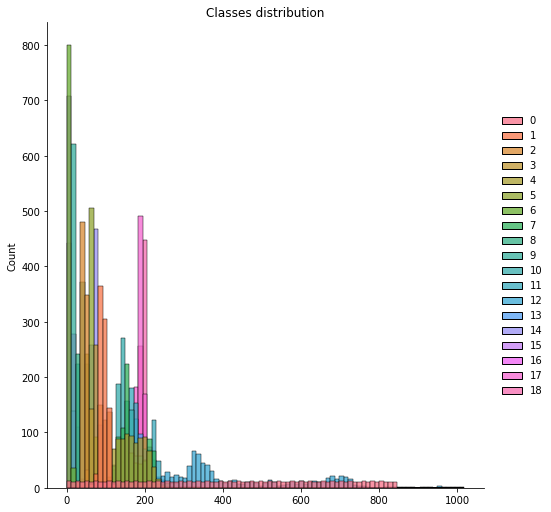

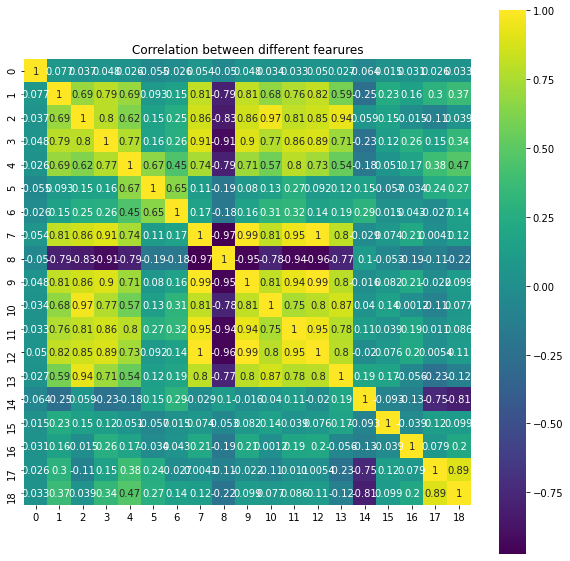

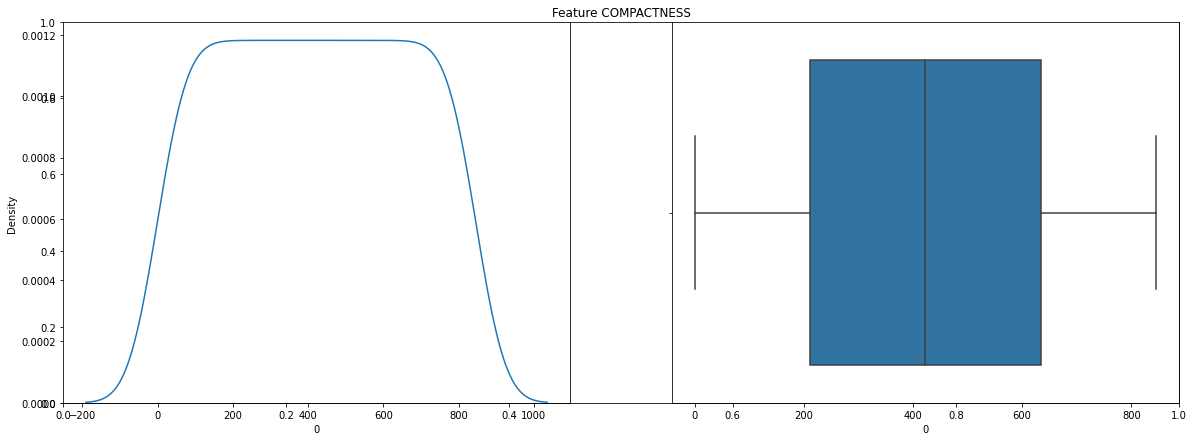

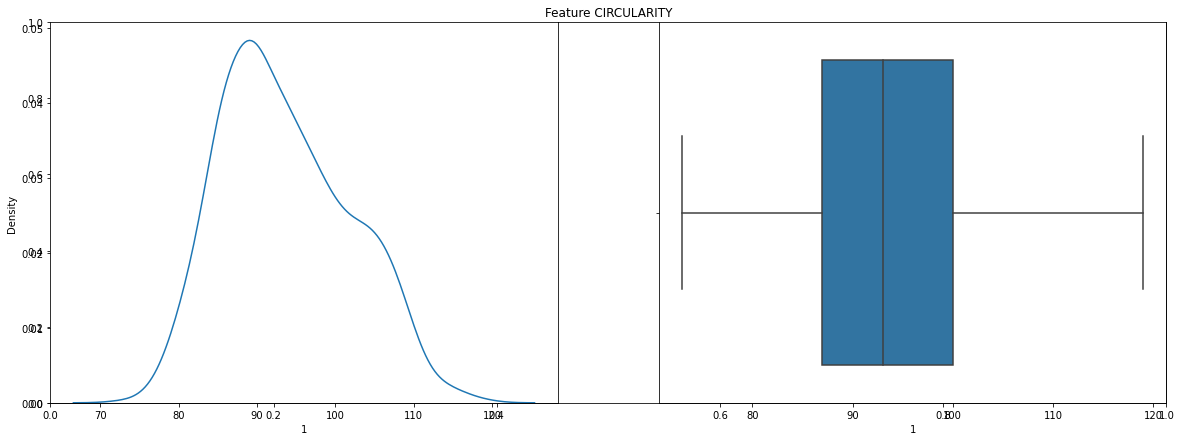

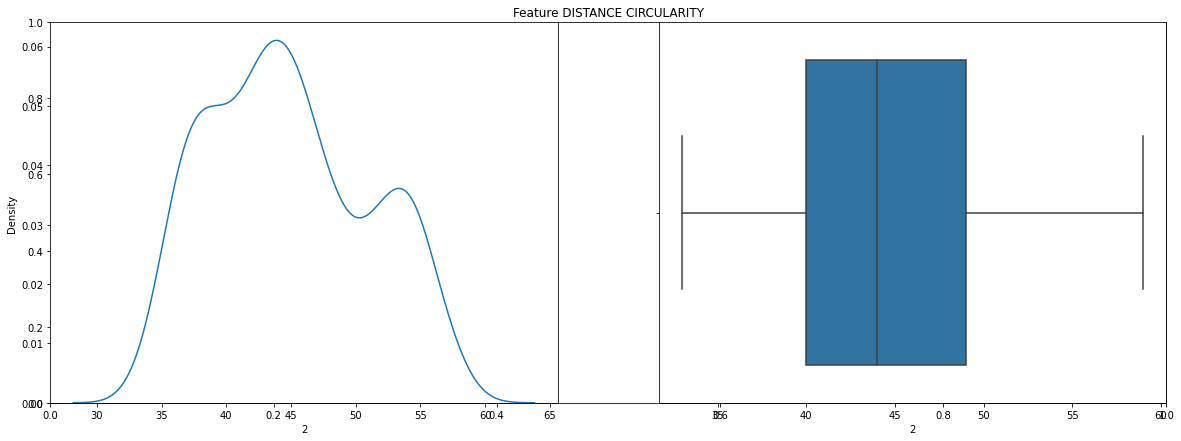

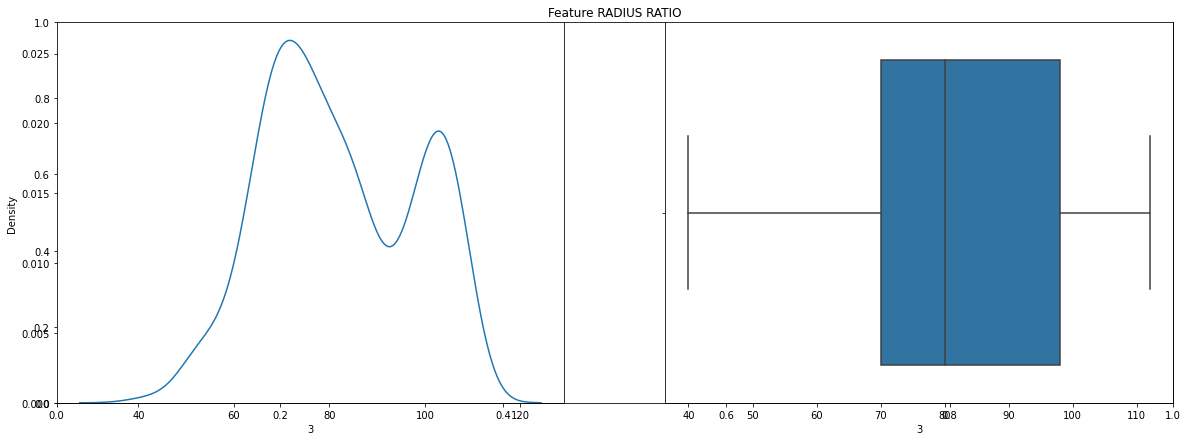

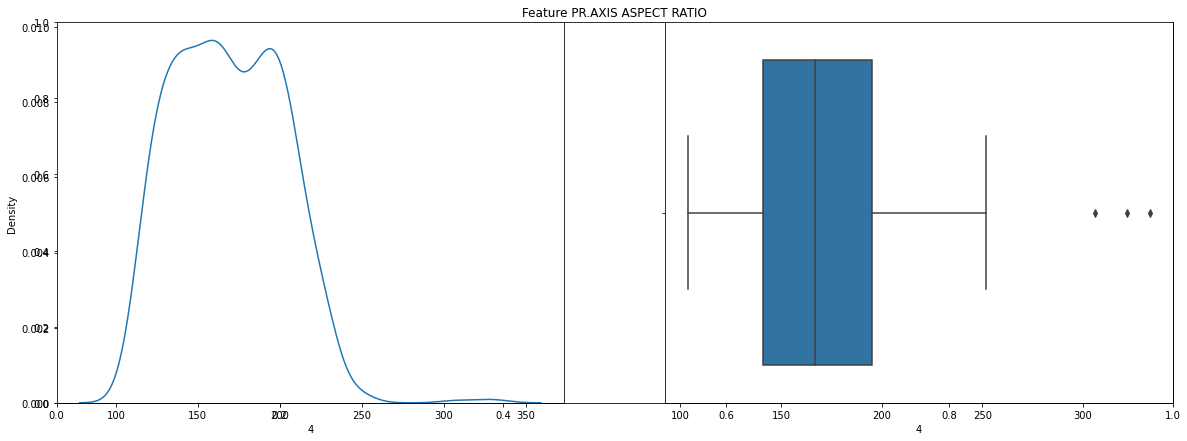

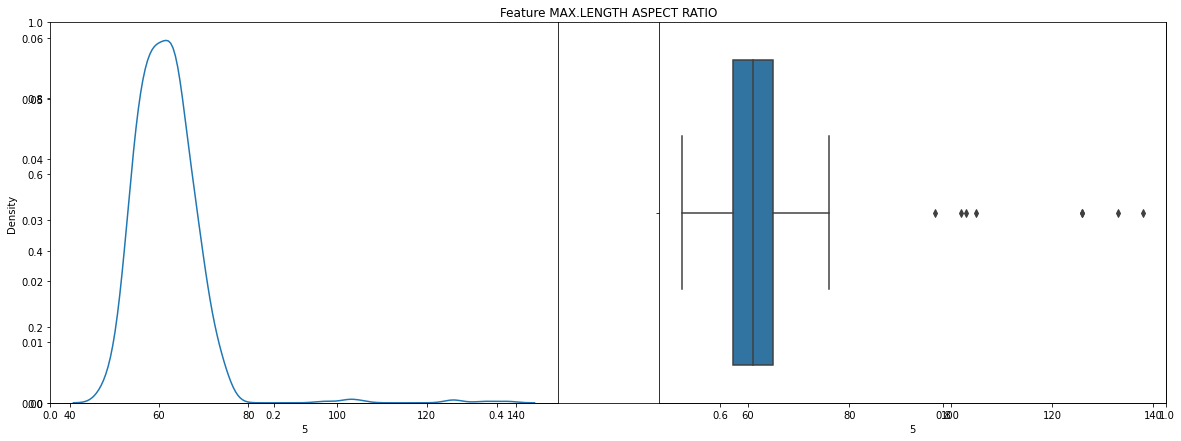

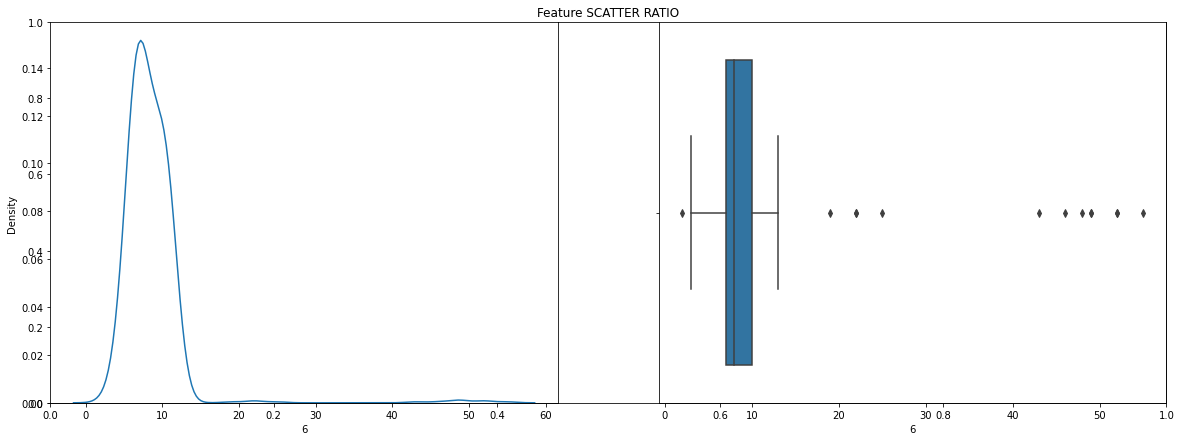

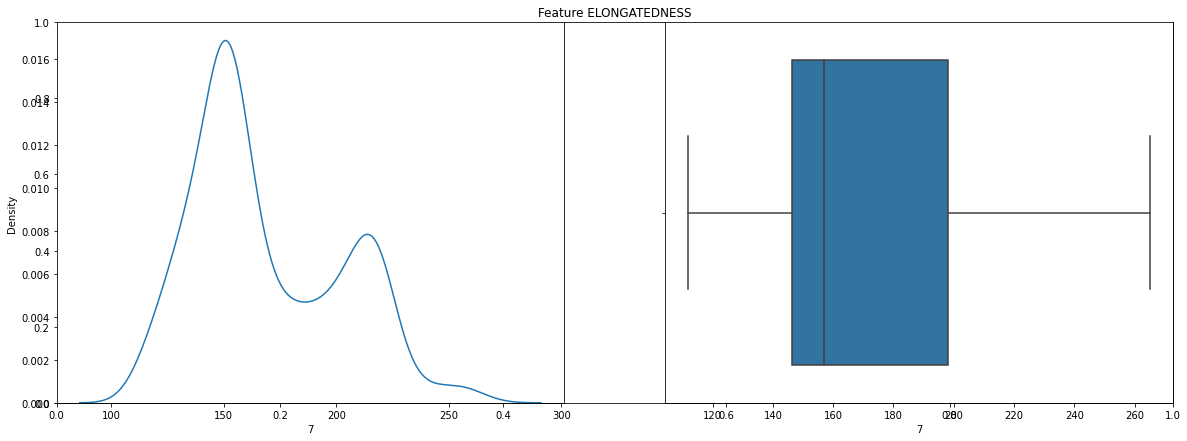

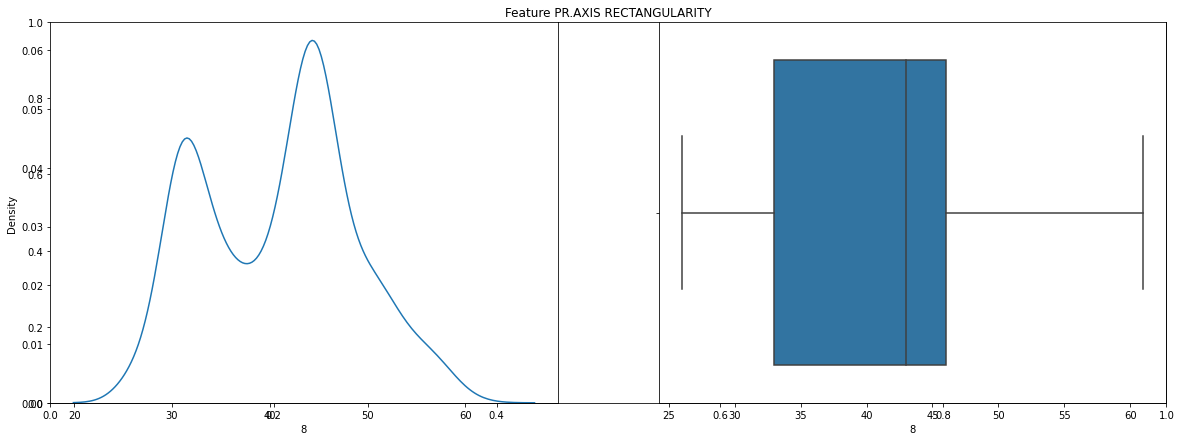

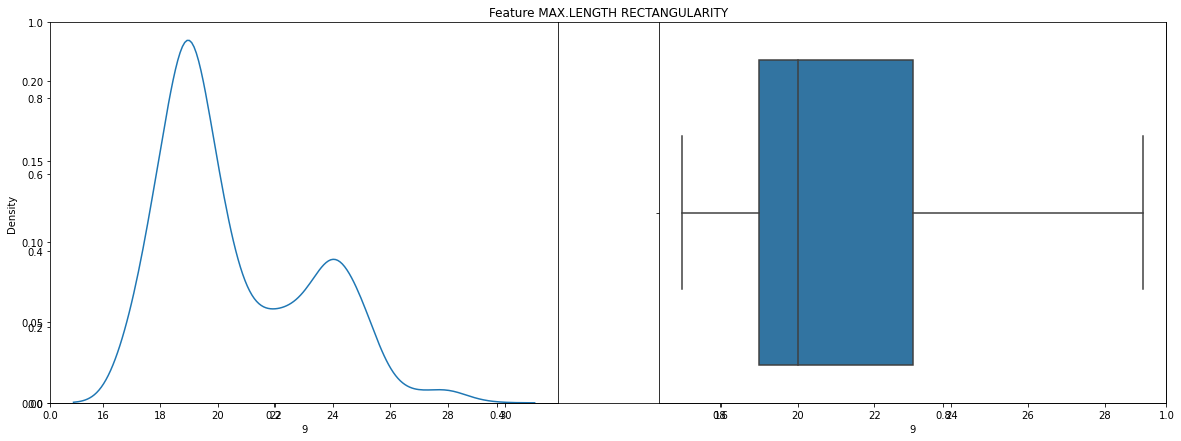

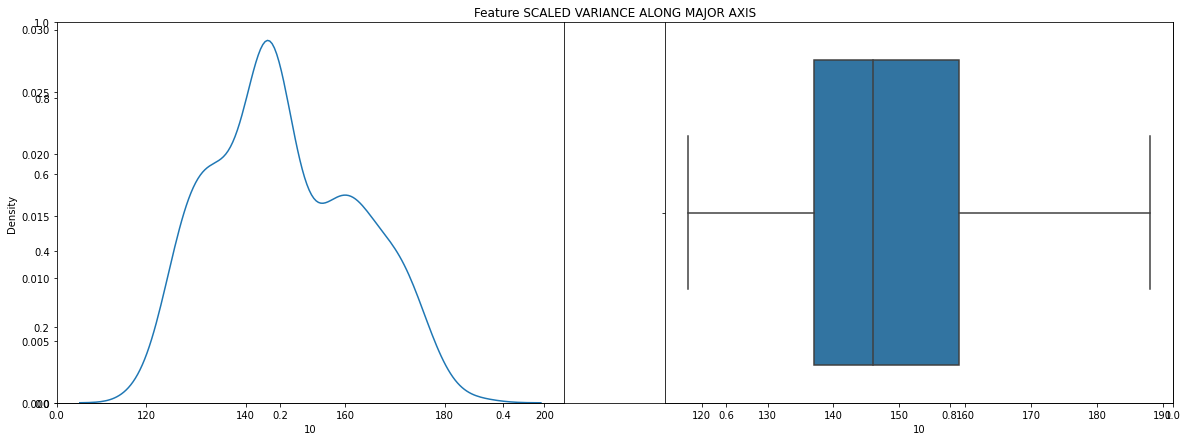

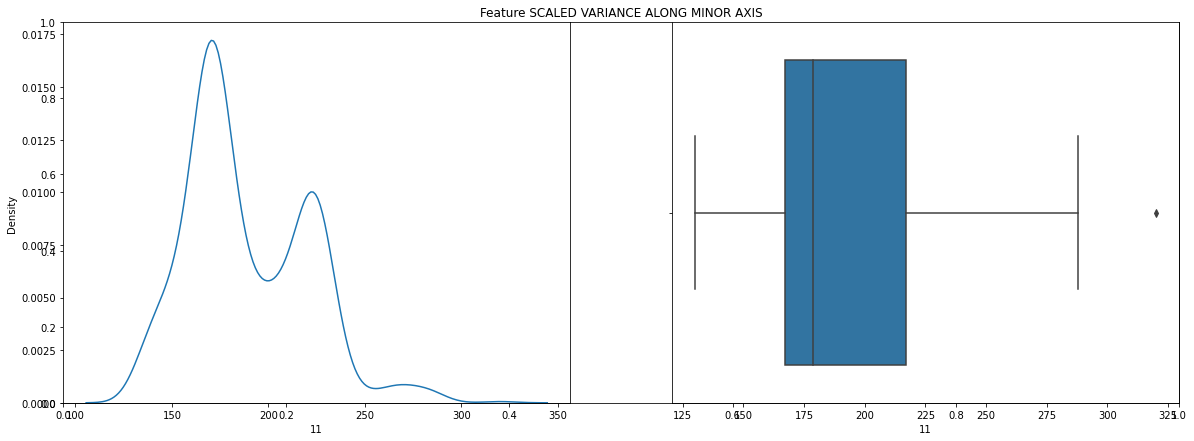

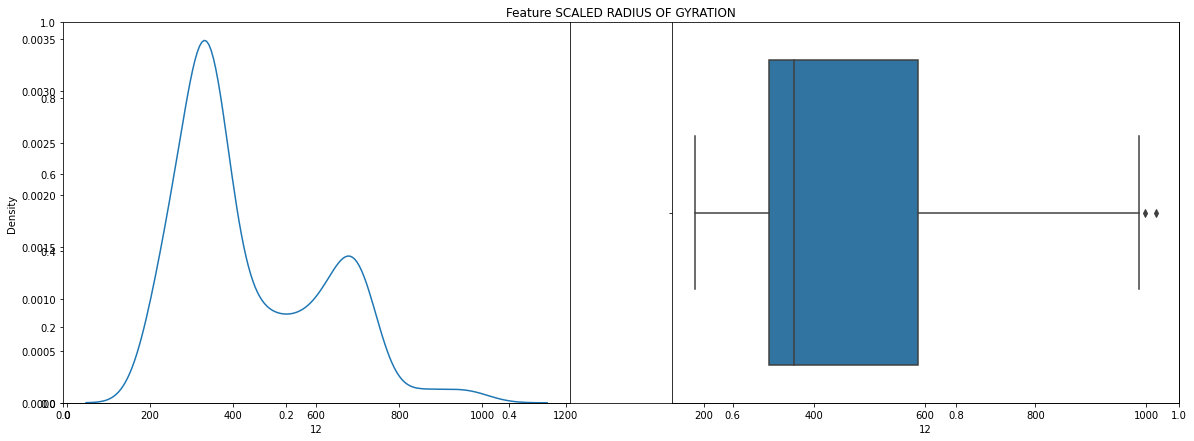

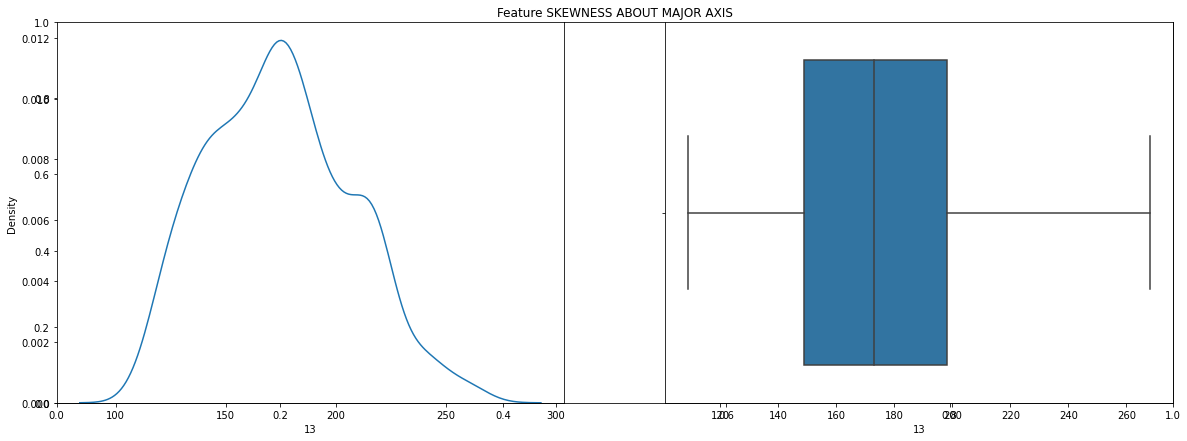

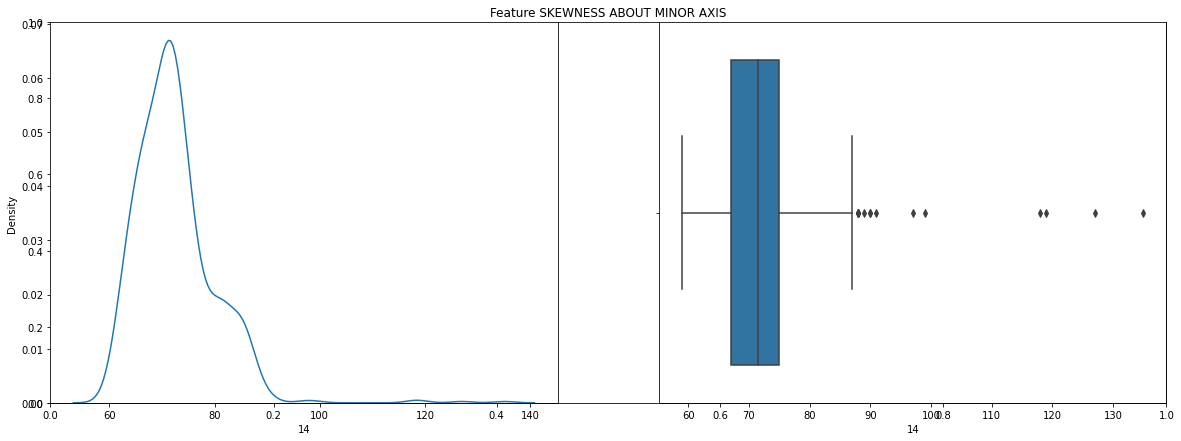

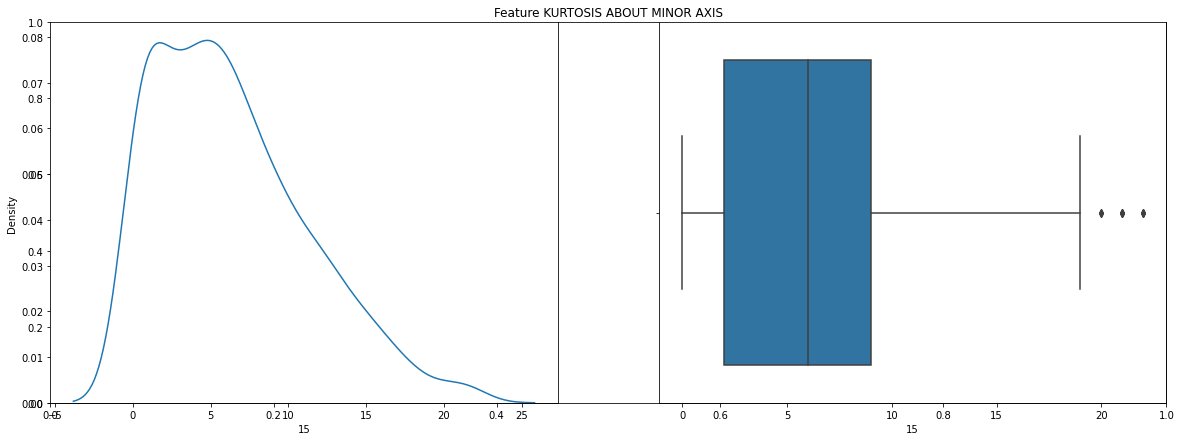

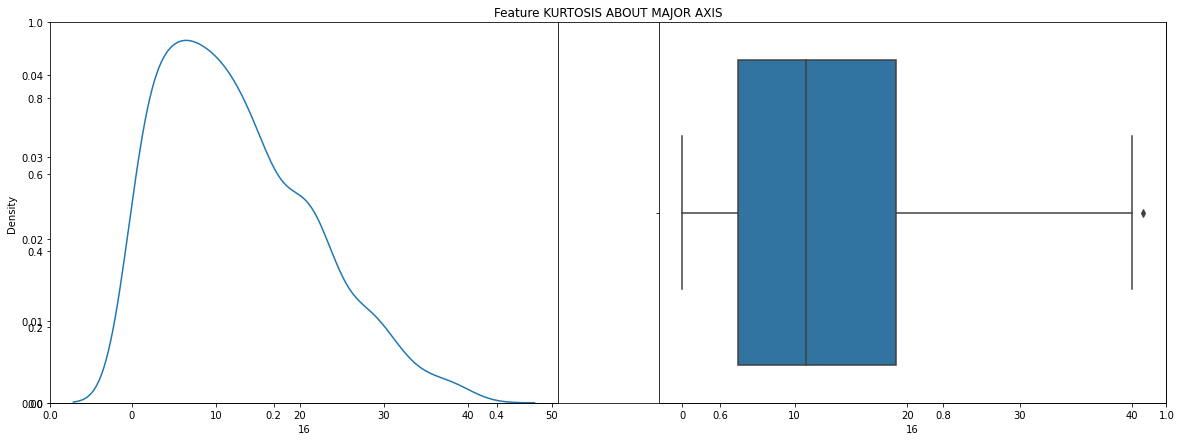

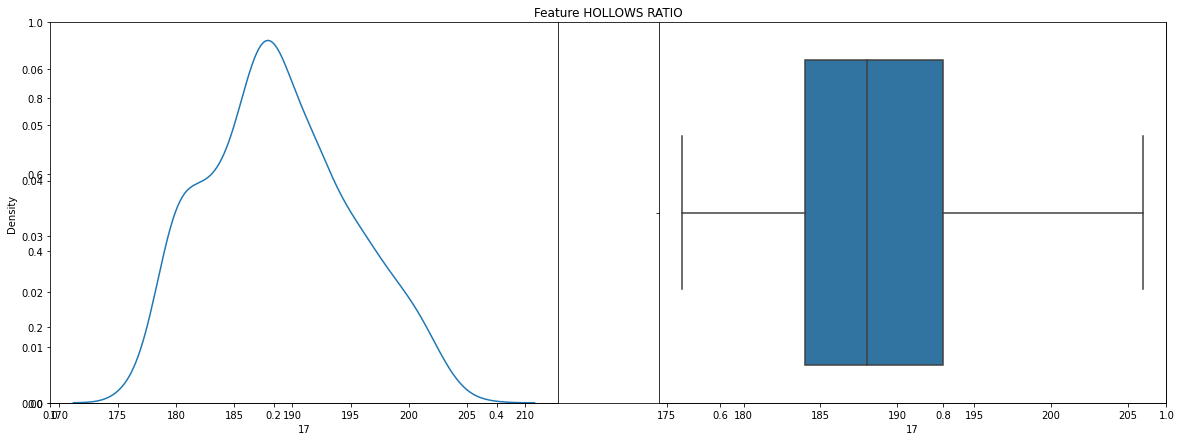

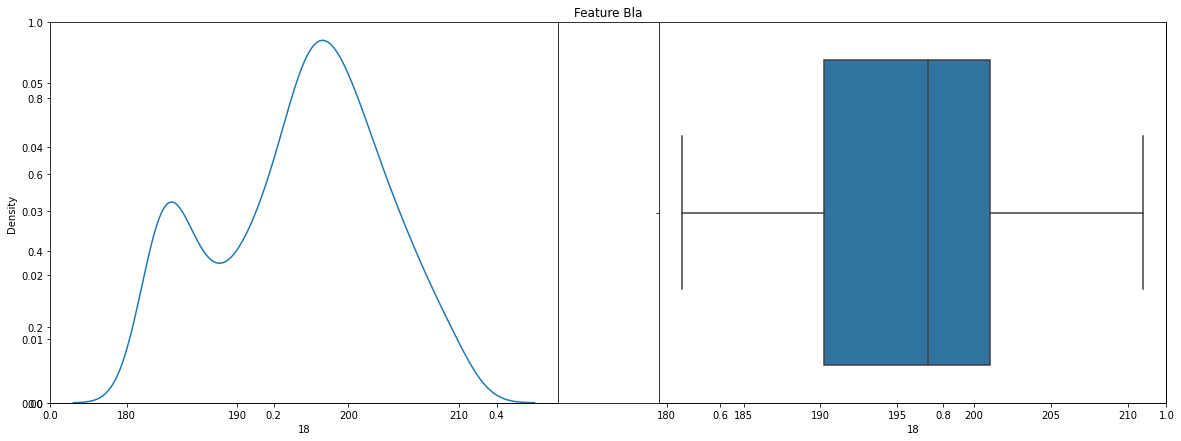

In [3]:
### YOUR CODE HERE
#0th step: encode target variable
target = pd.Series(LabelEncoder().fit_transform(target.astype(str)))   
#1st step: find missing values
print("Null value count:\n", dataset.iloc[:, :-1].isnull().sum().T)

#2nd step: statistical analysis
def plot_stats(data = data):
    #plotting classes distributions:
    sns.displot(data, multiple = "stack", height = 7); plt.title("Classes distribution"); plt.show()
    # here we can see that we should scale some features because for classifiers it is more less computationaly 
    # expensive and more conditioned to work with this task
    
    
    #and let's get correlation heatmap to detect multicol. features
    plt.figure(figsize = (10, 10))
    sns.heatmap(data.corr(), vmax = 1, square = True, annot = True, cmap = 'viridis')
    plt.title('Correlation between different fearures'); plt.show()
    #note: here we have a lot correlated features: we need to get rid of part of them
    
    
    #let's look at boxplots and KDE's (kernel distrs estimation) to:
    # 1) detect outliers and filter them by IQR
    # 2) look at skewness and other properties of classes distrs.
 
    
    for c in data.columns:
        fig = plt.figure(figsize = (20, 7))
        plt.title("Feature {}".format(features[int(c)]))
        gs = gridspec.GridSpec(1, 2)
        ax = []
        for i in range(2):
            ax.append(fig.add_subplot(gs[i]))
            
        sns.kdeplot(data[c], ax = ax[0])
        sns.boxplot(data[c], ax = ax[1])
        
plot_stats()

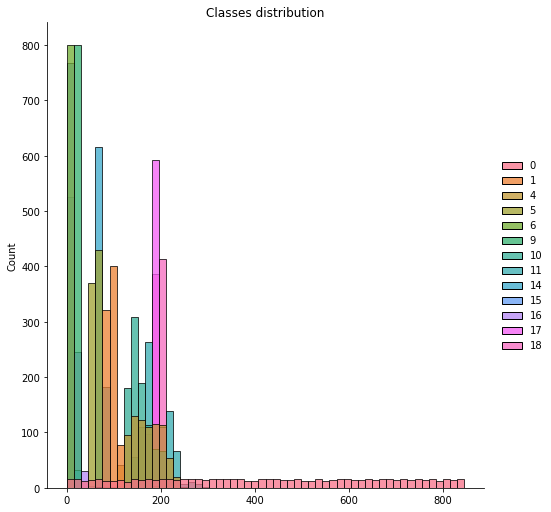

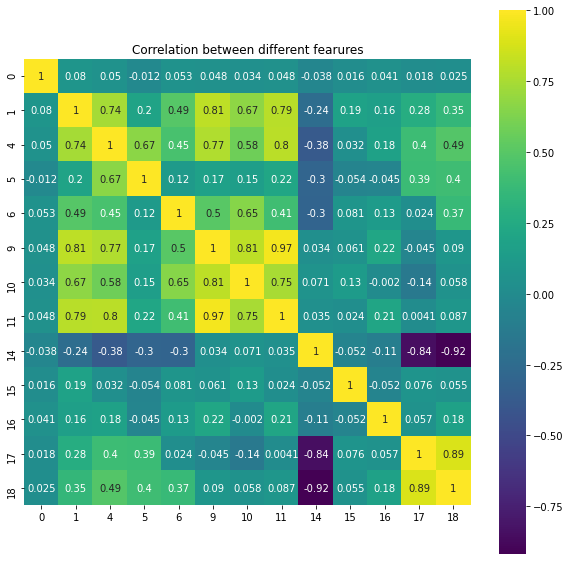

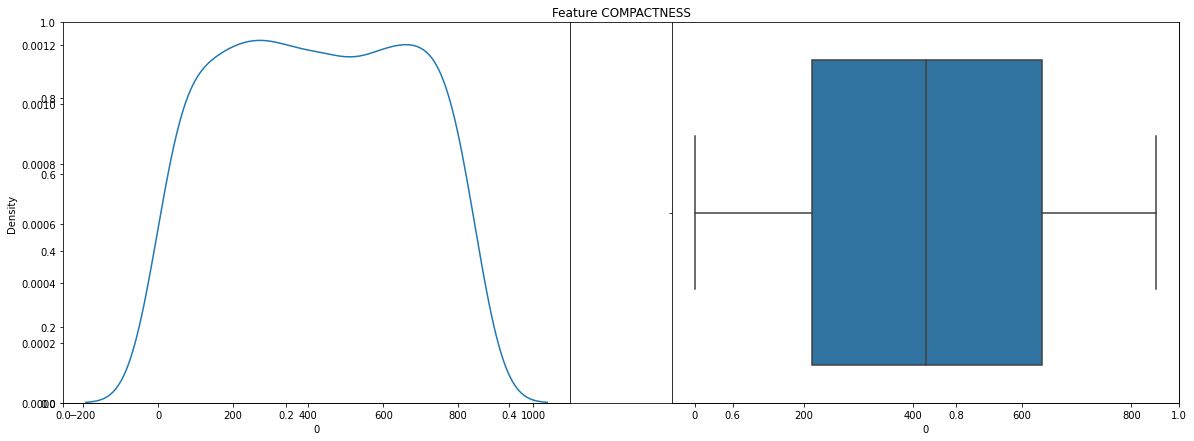

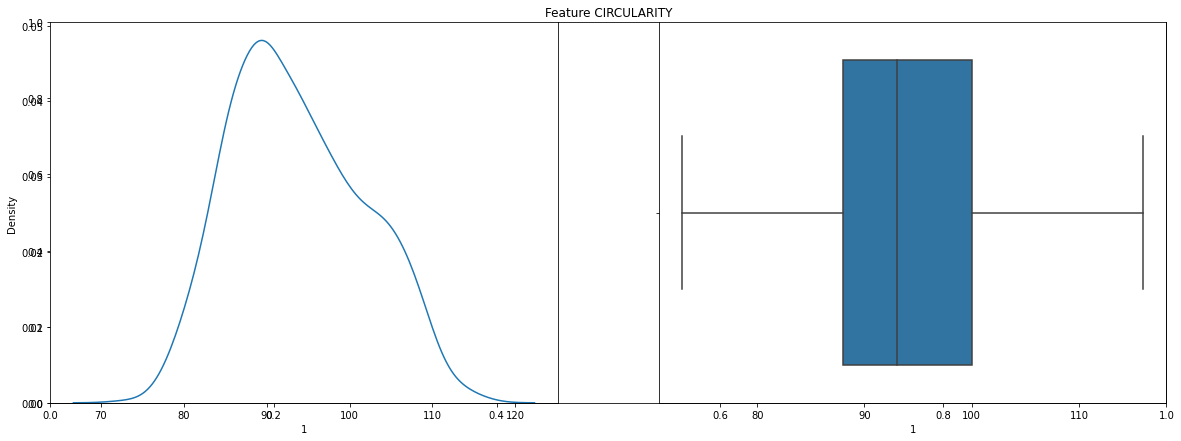

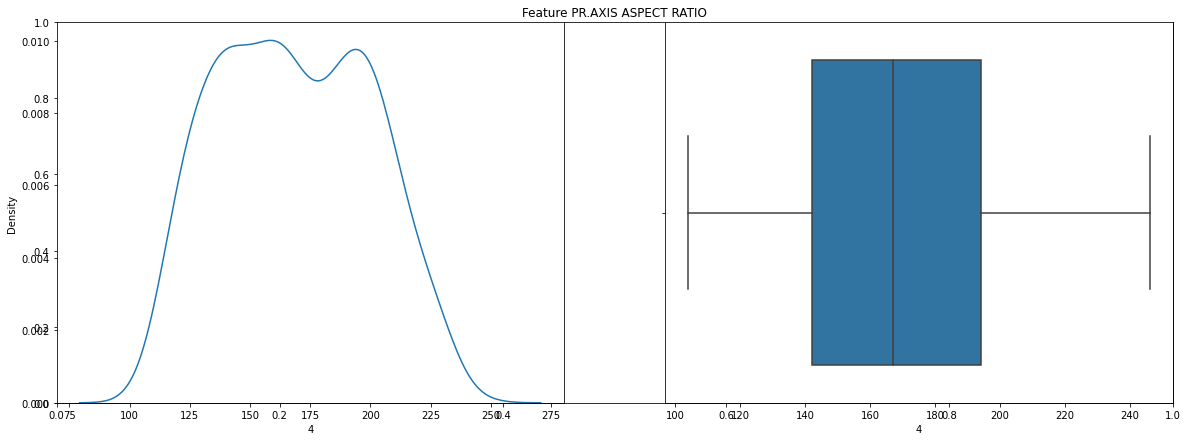

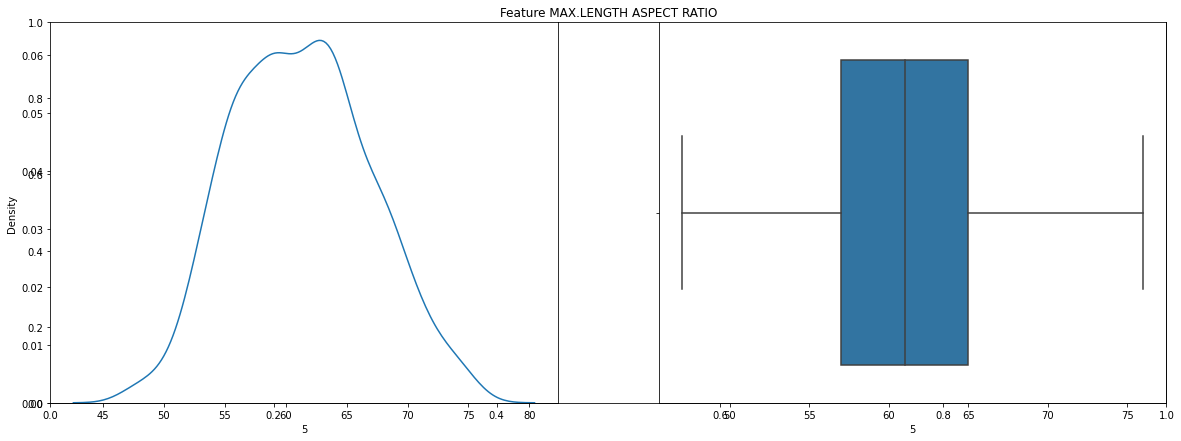

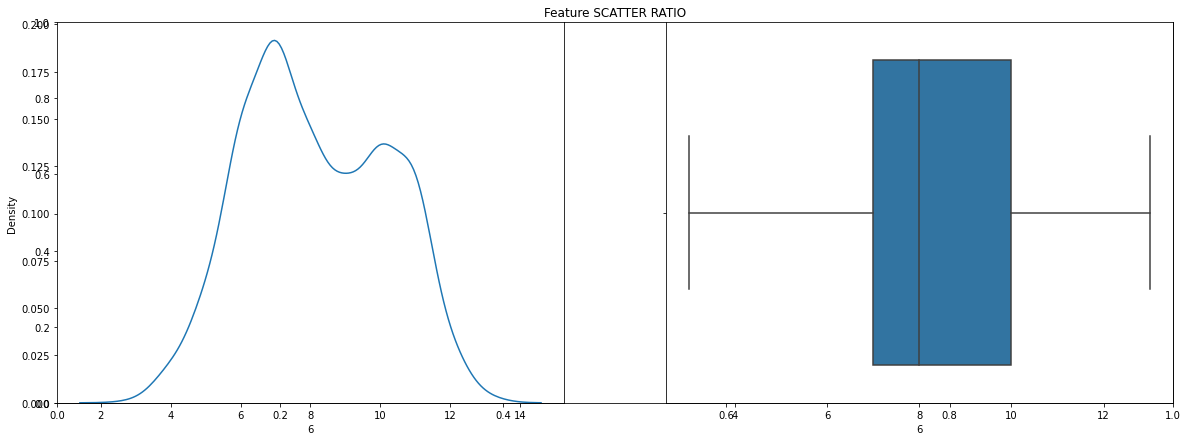

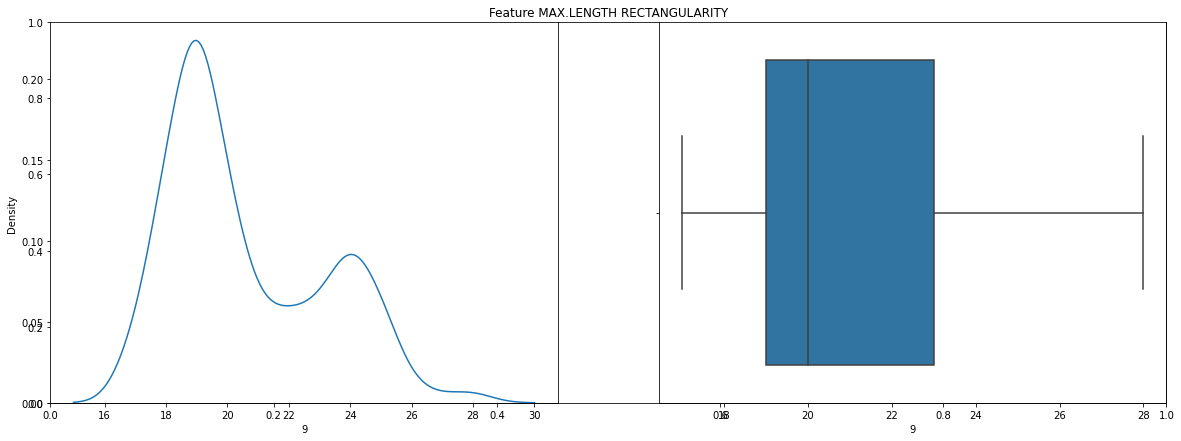

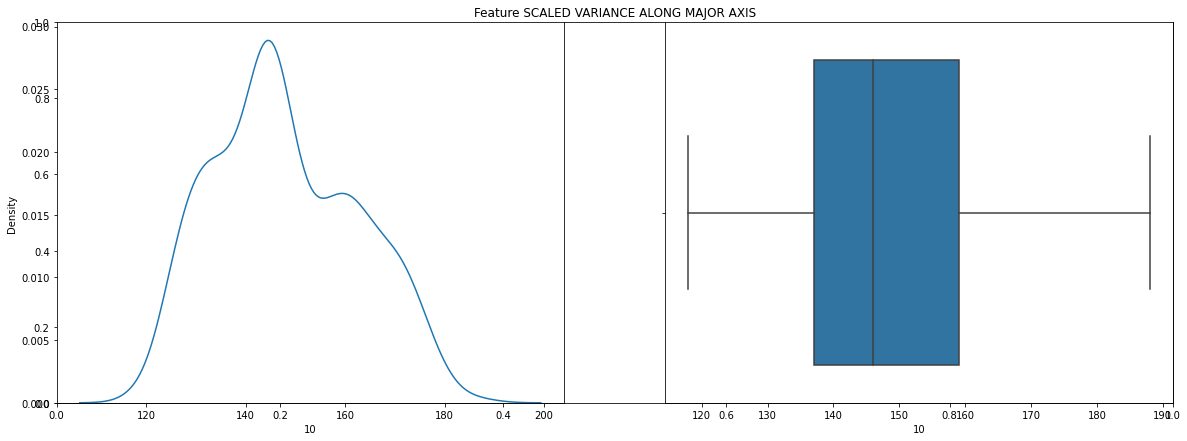

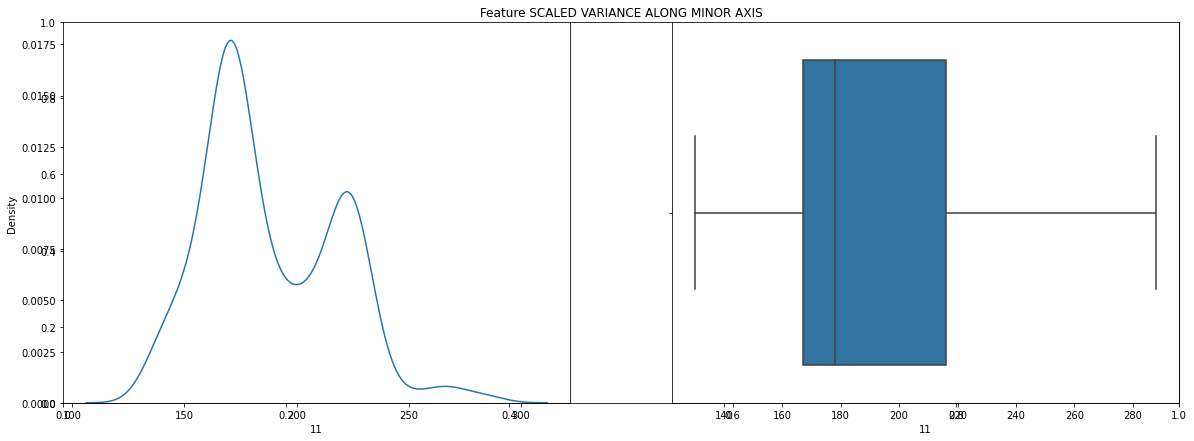

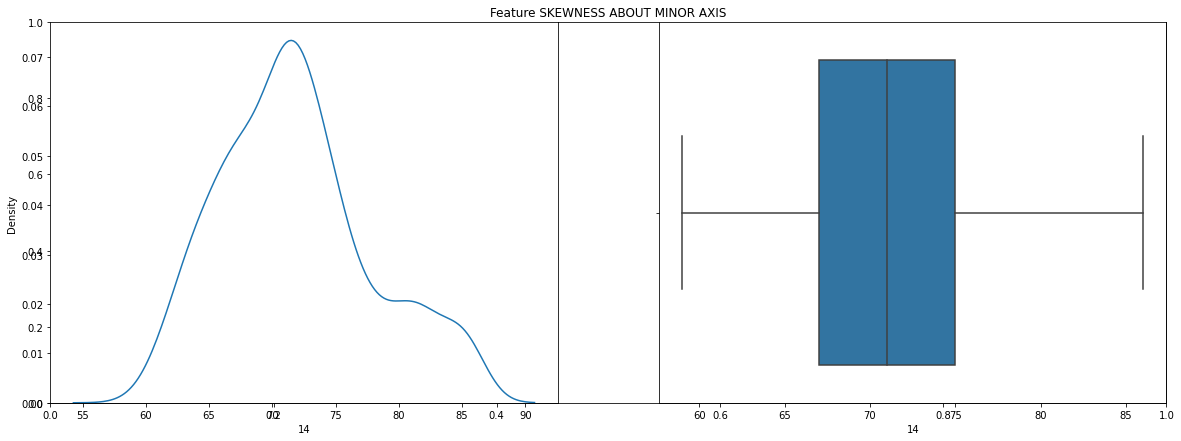

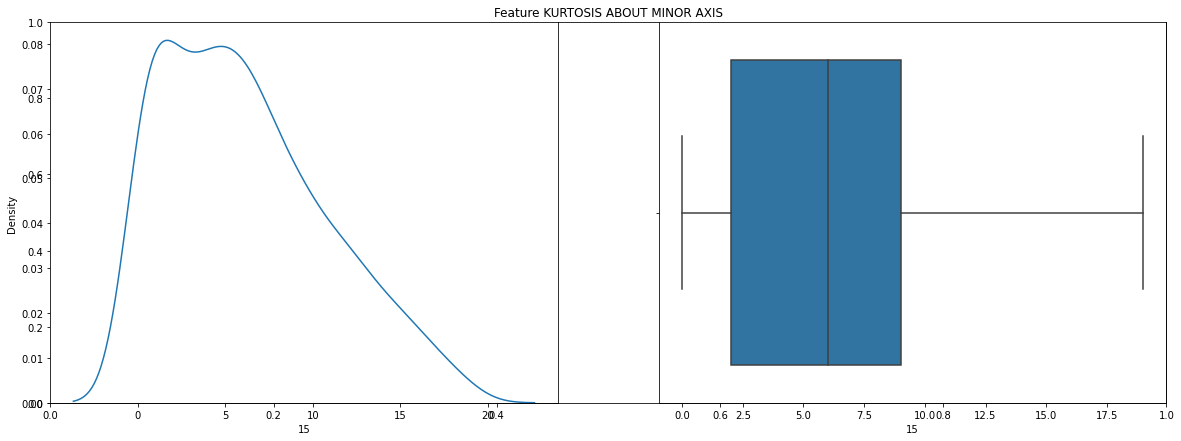

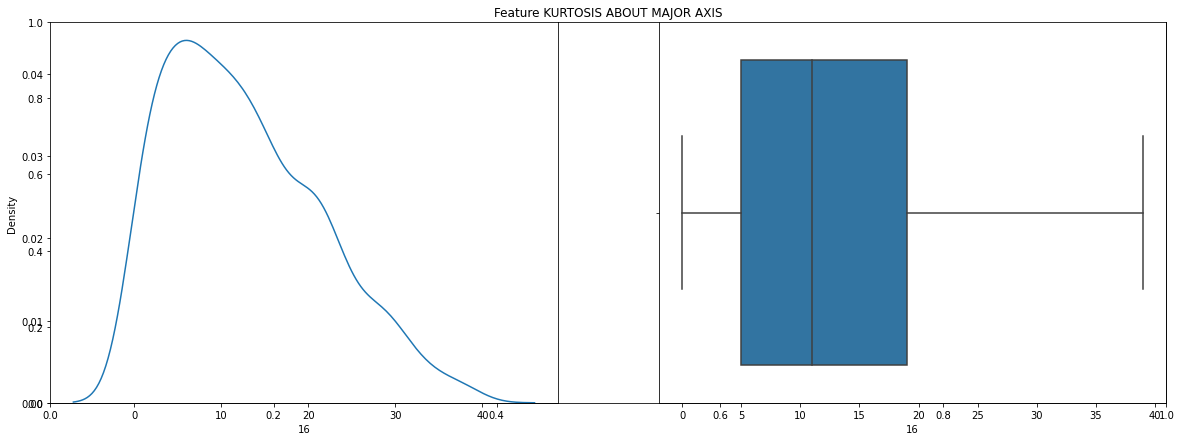

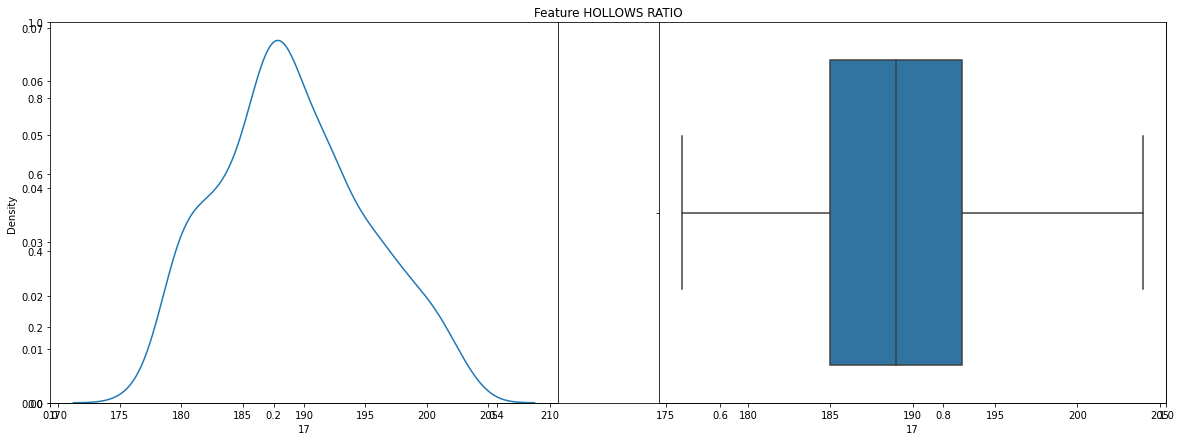

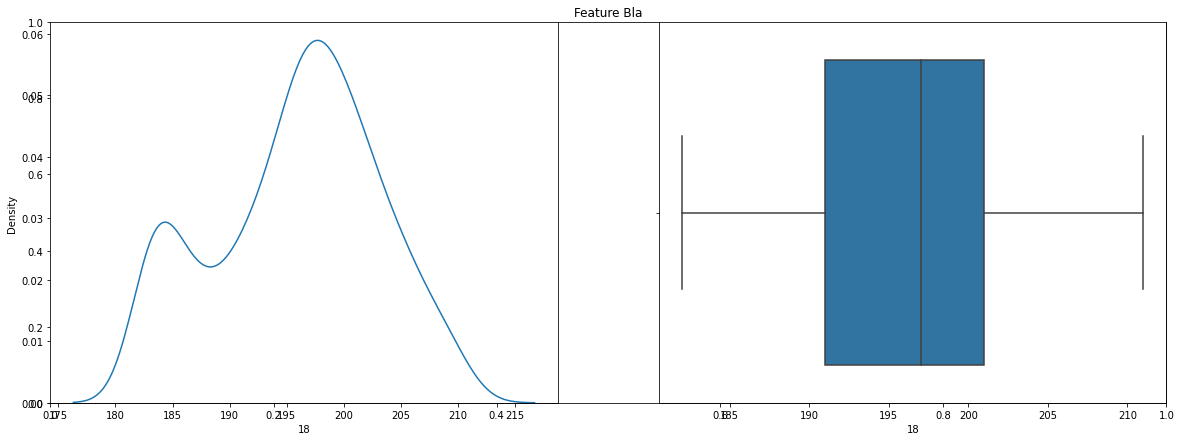

In [4]:
#let's note that featues 16, 15, 14, 12, 11, 6, 5, 4 have outliers. Let's filter them by IQR   
#how we can see, distributions not so skewed 
outliers_f = [4, 5, 6, 11, 12, 14, 15, 16]
indexes = []
for ind in outliers_f:
    upper_q = np.percentile(data.iloc[:, ind], 75)
    under_q = np.percentile(data.iloc[:, ind], 25)  
    IQR = (upper_q - under_q) * 1.5
    quatilies = (under_q - IQR, upper_q + IQR) 
    for str_ind in range(data.shape[0]):
        if data.iloc[str_ind, ind] <= quatilies[0] or \
        data.iloc[str_ind, ind] >= quatilies[1]: indexes.append(str_ind)  
            
data.drop(labels = list(set(indexes)), axis = 0, inplace = True)
target.drop(labels = list(set(indexes)), axis = 0, inplace = True)
data.drop(columns = list([2, 3, 7, 8, 12, 13]), inplace = True) 
plot_stats(data)

In [5]:
print("Data shape: {}, trainig shape {}".format(data.shape, target.shape))
data = data.values.astype(int); target = target.values
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size = 0.25)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Data shape: (801, 13), trainig shape (801,)
(600, 13) (600,) (201, 13) (201,)


#### 2.1. Basic logistic regression
* Find optimal hyperparameters for logistic regression with cross-validation on the `train` data (small grid/random search is enough, no need to find the *best* parameters).

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` `tol=1e-3` and ` max_iter=500`.*

In [6]:
### YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, ParameterGrid, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [7]:
def draw_table(d: dict, title: str, plot_metrics = False, n = None):
    print("{}: ".format(title))
    x = pd.DataFrame.from_dict(d, orient = 'index', columns = ['accuracy', 'f1_score'])
    print("Maximum by f1_score = {} in model \n {}".format(x.f1_score.max(), \
                                                           x[x.f1_score == x.f1_score.max()].index))
    if plot_metrics:
        plt.plot(n, x.accuracy.values); plt.title("Accuracy"); plt.xlabel("# of estimators"); plt.show()
        plt.plot(n, x.f1_score.values); plt.title("F1-score"); plt.xlabel("# of estimators"); plt.show()
    return ast.literal_eval(x[x.f1_score == x.f1_score.max()].index[0])
    

LogisticRegression: 
Maximum by f1_score = 0.6092644988011431 in model 
 Index(['{'C': 0.5, 'l1_ratio': 0.0, 'penalty': 'l2'}'], dtype='object')


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

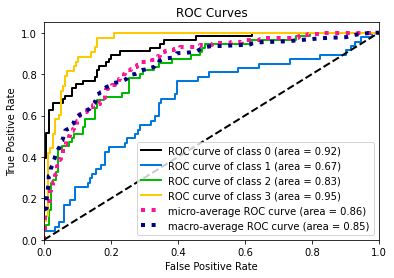

In [8]:
import warnings
warnings.simplefilter('ignore')

grid = ParameterGrid({'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                      'C': [0.01, 0.1, 0.5, 1.0, 10.],
                     'l1_ratio': [0.0, 0.1, 0.5, 1.0]})

def print_dict(d: dict, title: str):
        print("{}: params  accuracy f1_score".format(title))
        for k, v in d.items():
            print("{} : {}".format(k,v))

cross_val = KFold(3, shuffle = True)
scores = dict()
for item in grid:
    list_of_scores = [[], []]
    for train_index, test_index in cross_val.split(X_train):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
        model = LogisticRegression(penalty = item['penalty'], multi_class = 'multinomial', solver = 'saga', 
                                  tol = 1e-3, random_state = 0, C = item['C'], l1_ratio = item['l1_ratio'])
        model.fit(x_train_fold, y_train_fold)
        list_of_scores[0].append(accuracy_score(y_test_fold, model.predict(x_test_fold)))
        list_of_scores[1].append(f1_score(y_test_fold, model.predict(x_test_fold), average = 'weighted'))
    scores[str(item)] = (np.mean(list_of_scores[0]), np.mean(list_of_scores[1]))
    
x = draw_table(scores, "LogisticRegression")
model = LogisticRegression(penalty = x["penalty"], multi_class = 'multinomial', solver = 'saga', 
                                  tol = 1e-3, random_state = 0, C = x['C'], l1_ratio = x['l1_ratio'])
model.fit(X_train, Y_train)
plot_roc(Y_test, model.predict_proba(X_test))

#### 2.2. PCA: explained variance plot
* Apply the PCA to the train part of the data. Build the explaided variance plot. 

*95% threshold because i liked this number a lot*

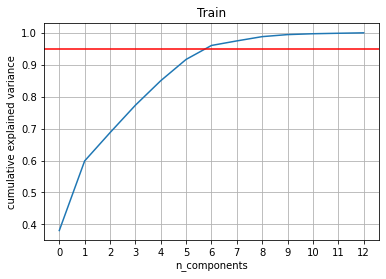

In [9]:
### YOUR CODE HERE
from sklearn.decomposition import PCA

def get_variance_plot(pca, title: str):
    percentage_var_explained = pca.explained_variance_ratio_;  
    variance = np.cumsum(percentage_var_explained)
    plt.title(title)
    plt.plot(variance)  
    plt.xticks(np.arange(0, 19, 1))
    plt.axis('tight'); plt.grid(True) 
    plt.xlabel('n_components') 
    plt.ylabel('cumulative explained variance')  
    plt.axhline(y = .95, color = 'r')
    plt.show()

pca = PCA()
pca.fit(StandardScaler().fit_transform(X_train.copy()))
get_variance_plot(pca, "Train")

#### 2.3. PCA trasformation
* Select the appropriate number of components. Briefly explain your choice. Should you normalize the data?

**Answer:**
Normalizing is preferable but not compulsory, but we need to *center* the data to simplify computations a lot because computational steps are:

`Data -> Covariance matrix -> eigenvalues`. 

I think, it is more convinient to have $F = X^T X$, not $F = (X-\mu I)^T (X-\mu I)$

*Use `fit` and `transform` methods to transform the `train` and `test` parts.*

In [10]:
### YOUR CODE HERE
from sklearn.pipeline import Pipeline
transform_data = Pipeline([('scaler', StandardScaler()), 
                           ('pca', PCA(n_components = 6))])
transform_data.fit(X_train)
X_train_pca, X_test_pca = transform_data.transform(X_train.copy()), transform_data.transform(X_test.copy())

**Note: From this point `sklearn` [Pipeline](https://scikit-learn.org/stable/modules/compose.html) might be useful to perform transformations on the data. Refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for more information.**

#### 2.4. Logistic regression on PCA-preprocessed data.
* Find optimal hyperparameters for logistic regression with cross-validation on the transformed by PCA `train` data.

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` and `tol=1e-3`*

LogisticRegression: 
Maximum by f1_score = 0.5757936854824831 in model 
 Index(['{'C': 1.0, 'l1_ratio': 1.0, 'penalty': 'l1'}'], dtype='object')


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

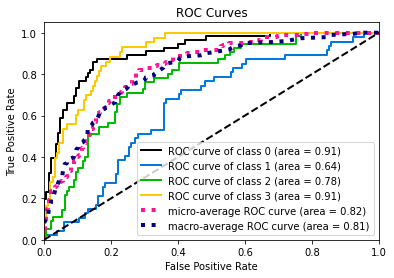

In [11]:
### YOUR CODE HERE
grid = ParameterGrid({'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                      'C': [0.01, 0.1, 0.5, 1.0, 10.],
                     'l1_ratio': [0.0, 0.1, 0.5, 1.0]})

cross_val = KFold(5, shuffle = True)
scores = dict()
for item in grid:
    list_of_scores = [[], []]
    for train_index, test_index in cross_val.split(X_train):
        x_train_fold = X_train_pca[train_index]
        x_test_fold = X_train_pca[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
        model = LogisticRegression(penalty = item['penalty'], multi_class = 'multinomial', solver = 'saga', 
                                  tol = 1e-3, random_state = 0, C = item['C'], l1_ratio = item['l1_ratio'])
        model.fit(x_train_fold, y_train_fold)
        list_of_scores[0].append(accuracy_score(y_test_fold, model.predict(x_test_fold)))
        list_of_scores[1].append(f1_score(y_test_fold, model.predict(x_test_fold), average = 'weighted'))
    scores[str(item)] = (np.mean(list_of_scores[0]), np.mean(list_of_scores[1]))

x_LR = draw_table(scores, "LogisticRegression")
model = LogisticRegression(penalty = x_LR["penalty"], multi_class = 'multinomial', solver = 'saga', 
                                  tol = 1e-3, random_state = 0, C = x_LR['C'], l1_ratio = x_LR['l1_ratio'])
model.fit(X_train_pca, Y_train)
plot_roc(Y_test, model.predict_proba(X_test_pca))

#### 2.5. Decision tree
* Now train a desicion tree on the same data. Find optimal tree depth (`max_depth`) using cross-validation.

* Measure the model quality using the same metrics you used above.

DecisionTreeClassifier: 
Maximum by f1_score = 0.583785137519507 in model 
 Index(['{'max_depth': 9}'], dtype='object')


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

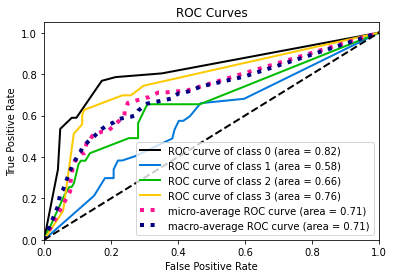

In [12]:
from sklearn.tree import DecisionTreeClassifier
grid = ParameterGrid({'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None]})

cross_val = KFold(3, shuffle = True)
scores = dict()
for item in grid:
    list_of_scores = [[], []]
    for train_index, test_index in cross_val.split(X_train):
        x_train_fold = X_train_pca[train_index]
        x_test_fold = X_train_pca[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
        model = DecisionTreeClassifier(max_depth = item['max_depth'], random_state = 0) 
        model.fit(x_train_fold, y_train_fold)
        list_of_scores[0].append(accuracy_score(y_test_fold, model.predict(x_test_fold)))
        list_of_scores[1].append(f1_score(y_test_fold, model.predict(x_test_fold), average = 'weighted'))
    scores[str(item)] = (np.mean(list_of_scores[0]), np.mean(list_of_scores[1]))

x_DT = draw_table(scores, "DecisionTreeClassifier")
model = DecisionTreeClassifier(max_depth = x_DT['max_depth'])
model.fit(X_train_pca, Y_train)
plot_roc(Y_test, model.predict_proba(X_test_pca))

#### 2.6. Bagging.
Here starts the ensembling part.

First we will use the __Bagging__ approach. Build an ensemble of $N$ algorithms varying N from $N_{min}=2$ to $N_{max}=100$ (with step 5).

We will build two ensembles: of logistic regressions and of decision trees.

*Comment: each ensemble should be constructed from models of the same family, so logistic regressions should not be mixed up with decision trees.*


*Hint 1: To build a __Bagging__ ensebmle varying the ensemble size efficiently you might generate $N_{max}$ subsets of `train` data (of the same size as the original dataset) using bootstrap procedure once. Then you train a new instance of logistic regression/decision tree with optimal hyperparameters you estimated before on each subset (so you train it from scratch). Finally, to get an ensemble of $N$ models you average the $N$ out of $N_{max}$ models predictions.*

*Hint 2: sklearn might help you with this taks. Some appropriate function/class might be out there.*

* Plot `f1` and `accuracy` scores plots w.r.t. the size of the ensemble.

* Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.

* How do you think, are the hyperparameters for the decision trees you found in 2.5 optimal for trees used in ensemble? 

LogisticRegression: 


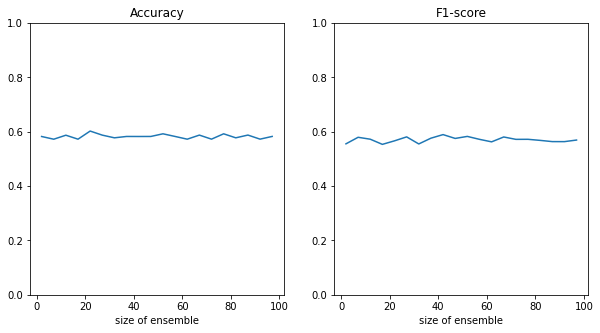

Optimal ensemble size of logistic regression:  42
f1_score  0.5893993052998676
DecisionTreeRegression: 


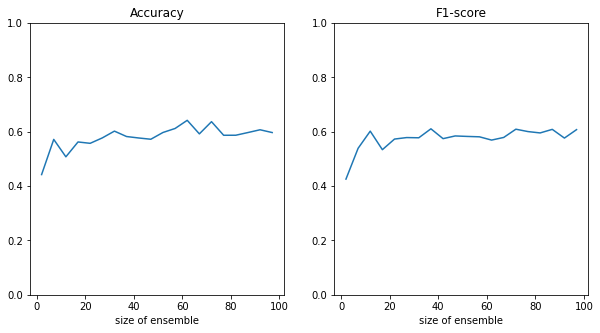

Optimal ensemble size of decision trees:  37
f1_score  0.61069301258101


In [24]:
##### YOUR CODE HERE
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
N_min = 2; N_max = 100; step = 5
Ns = np.arange(N_min, N_max, step = step)

def get_models(base, data = X_train_pca, target = Y_train, Ns = Ns):
    models = dict()
    for N in Ns:
        models[str(N)] = BaggingClassifier(base_estimator = base, n_estimators = N, 
                                           oob_score = True, bootstrap = True)
        models[str(N)].fit(data, target)
    return models

def evaluate_model(model, data = X_test_pca, target = Y_test, mode = 'crossval'):
    if mode == 'crossval':
        cv = KFold(5)
        acc_score = cross_val_score(model, data, target, scoring = 'accuracy', cv = cv).mean()
        f1_score_ = cross_val_score(model, data, target, scoring = 'f1_weighted', cv = cv).mean()
        return acc_score, f1_score_
    if mode == 'noncrossval':
        acc_score = model.score(data, target)
        f1_score_ = f1_score(target, model.predict(data), average = 'weighted')
        return acc_score, f1_score_
    else: return 0.0, 0.0

LRs = get_models(LogisticRegression(multi_class = 'multinomial', solver = 'saga', tol = 1e-3, random_state = 0))
DTs = get_models(DecisionTreeClassifier(max_depth = x_DT['max_depth'], random_state = 0))

def plot_results(models, data = X_test_pca, target = Y_test):
    f1s, accs = [], []
    fig = plt.figure(figsize = (10, 5))
    gs = gridspec.GridSpec(1, 2)
    ax = np.empty([2], dtype = 'object')
    for i in range(2):
        ax[i] = fig.add_subplot(gs[i])
        
    for name, model in models.items():
        acc, f1 = evaluate_model(model, data, target, "crossval")
        accs.append(acc)
        f1s.append(f1)
    ax[0].plot(Ns, accs); ax[0].set_title("Accuracy"); 
    ax[0].set_xlabel("size of ensemble"); ax[0].set_ylim((0.0, 1.0))
    ax[1].plot(Ns, f1s); ax[1].set_title("F1-score");
    ax[1].set_xlabel("size of ensemble"); ax[1].set_ylim((0.0, 1.0))
    plt.show()
    return accs, f1s
# with cross-validation
print("LogisticRegression: ")
_, lrf1s = plot_results(LRs)
print("Optimal ensemble size of logistic regression: ", N_min + step * (np.argmax(lrf1s)))
print("f1_score ", np.max(lrf1s))
print("\n DecisionTreeRegression: ")
_, dtf1s = plot_results(DTs)
print("Optimal ensemble size of decision trees: ", N_min + step * (np.argmax(dtf1s)))
print("f1_score ", np.max(dtf1s))

Optimal number of algorithms is around 25-80 because our dependecy is too noisy.
I think, yes, we should use trees with optimal depth to overfit them better -> bagging will work better

#### 2.7. Random Forest
Now we will work with the Random Forest (its `sklearn` implementation).

* Plot `f1` and `accuracy` scores plots w.r.t. the number of trees in Random Forest.

* What is the optimal number of trees you've got? Is it different from the optimal number of logistic regressions/decision trees in 2.6? Explain the results briefly.

DecisionTreeClassifier: 
Maximum by f1_score = 0.7478523556944493 in model 
 Index(['{'n_trees': 92}'], dtype='object')


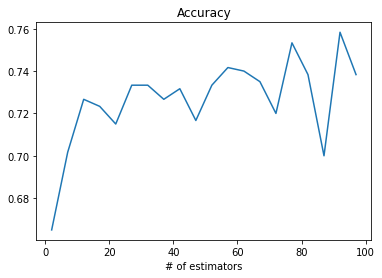

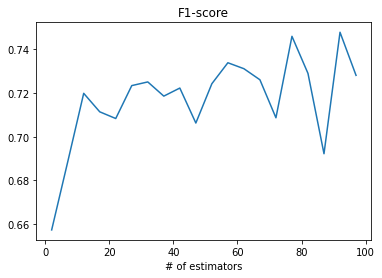

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

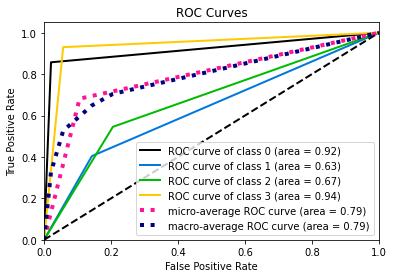

In [25]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
n_trees = np.arange(2, 102, 5)
grid = ParameterGrid({'n_trees': n_trees})

cross_val = KFold(3, shuffle = True)
scores = dict()
for item in grid:
    list_of_scores = [[], []]
    for train_index, test_index in cross_val.split(X_train):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
        model = RandomForestClassifier(n_estimators = item['n_trees'], oob_score = True,
                                       max_depth = x_DT['max_depth'], random_state = 0) 
        model.fit(x_train_fold, y_train_fold)
        list_of_scores[0].append(accuracy_score(y_test_fold, model.predict(x_test_fold)))
        list_of_scores[1].append(f1_score(y_test_fold, model.predict(x_test_fold), average = 'weighted'))
    scores[str(item)] = (np.mean(list_of_scores[0]), np.mean(list_of_scores[1]))
x_RF = draw_table(scores, "DecisionTreeClassifier", True, n_trees)
model = DecisionTreeClassifier(max_depth = x_RF['n_trees'])
model.fit(X_train, Y_train)
plot_roc(Y_test, model.predict_proba(X_test))
# YOUR CODE HERE

**Bagging** (Bootstrap Aggregation) is used when our goal is to reduce the variance of a decision tree. Here idea is to create several subsets of data from training sample chosen randomly with replacement. Now, each collection of subset data is used to train their decision trees. As a result, we end up with an ensemble of different models. Average of all the predictions from different trees are used which is more robust than a single decision tree.

**Random Forest** is an extension over bagging. It takes one extra step where in addition to taking the random subset of data, it also takes the random selection of features rather than us ing all features to grow trees. When you have many random trees.

These 2 methods use different approach, so RF and Bagging use approx the same number of esimators to achieve their best result. RF works better because we're 'bootstraping' not objects but selecting a random subspace of features

In [17]:
forest = RandomForestRegressor(n_estimators = 1000, random_state = 0)
forest.fit(X_train_pca, Y_train)
forest.feature_importances_  #features are almost equally important


array([0.20175087, 0.17434261, 0.27691196, 0.12765293, 0.05193641,
       0.16740523])

#### 2.8. Learning curve
Your goal is to estimate, how does the model behaviour change with the increase of the `train` dataset size.

* Split the training data into 10 equal (almost) parts. Then train the models from above (Logistic regression, Desicion Tree, Random Forest) with optimal hyperparameters you have selected on 1 part, 2 parts (combined, so the train size in increased by 2 times), 3 parts and so on.

* Build a plot of `accuracy` and `f1` scores on `test` part, varying the `train` dataset size (so the axes will be score - dataset size.

* Analyse the final plot. Can you make any conlusions using it? 

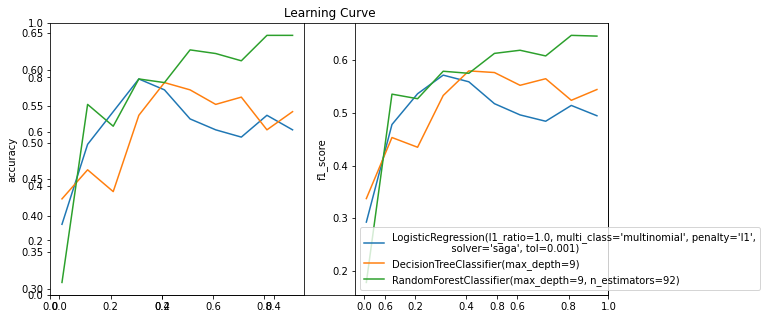

In [38]:
# YOUR CODE HERE
split_size = np.arange(0.01, 1.0, 0.1)
models = [LogisticRegression(penalty = x_LR["penalty"], multi_class = 'multinomial', solver = 'saga', \
                            tol = 1e-3, C = x_LR['C'], l1_ratio = x_LR['l1_ratio']), 
          DecisionTreeClassifier(max_depth = x_DT['max_depth']), 
          RandomForestClassifier(x_RF['n_trees'], max_depth = x_DT['max_depth'])]
models_results = {"accuracy": [], "f1_score": []}
for model in models:
    accs, f1s = [], []
    for split_ in split_size:
#         idx = np.random.choice(np.arange(0, X_train.shape[0]), int(split_ * len(X_train)))
        idx = int(split_ * len(X_train))
        model.fit(X_train_pca[:idx, :], Y_train[:idx])
        acc, f1 = evaluate_model(model, mode = 'noncrossval')
        accs.append(acc)
        f1s.append(f1)
    models_results['accuracy'].append(accs)
    models_results['f1_score'].append(f1s)

fig = plt.figure(figsize = (10, 5))
plt.title("Learning Curve")
gs = gridspec.GridSpec(1, 2)
ax = np.empty([2], dtype = 'object')
for i in range(2):
    ax[i] = fig.add_subplot(gs[i])
for ind in range(3):
    ax[0].plot(split_size, models_results['accuracy'][ind], label = str(models[ind]))
    ax[0].set_ylabel('accuracy')
    ax[1].plot(split_size, models_results['f1_score'][ind], label = str(models[ind]))
    ax[1].legend(loc = 'best'); ax[1].set_ylabel('f1_score')

We shoud notice that with increasing train part our score in steadly rising but then stays almost stable, RF is the best one.